<a href="https://colab.research.google.com/github/gabbylancs/ComputerVisionExamples/blob/main/StraightOrJunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
from pathlib import Path
import os
import pandas as pd
import random
from PIL import Image
import torch.optim as optim
from sklearn.model_selection import KFold

/content/drive/MyDrive/a_1_frames/images directory exists.
There are 5 directories and 0 images in '/content/drive/MyDrive/a_1_frames/images'.
There are 2 directories and 0 images in '/content/drive/MyDrive/a_1_frames/images/test'.
There are 0 directories and 194 images in '/content/drive/MyDrive/a_1_frames/images/test/straight'.
There are 0 directories and 99 images in '/content/drive/MyDrive/a_1_frames/images/test/turn'.
There are 2 directories and 0 images in '/content/drive/MyDrive/a_1_frames/images/train'.
There are 0 directories and 5393 images in '/content/drive/MyDrive/a_1_frames/images/train/straight'.
There are 0 directories and 3055 images in '/content/drive/MyDrive/a_1_frames/images/train/turn'.
There are 2 directories and 0 images in '/content/drive/MyDrive/a_1_frames/images/a_1_testframes'.
There are 0 directories and 7 images in '/content/drive/MyDrive/a_1_frames/images/a_1_testframes/straight'.
There are 0 directories and 334 images in '/content/drive/MyDrive/a_1_frames

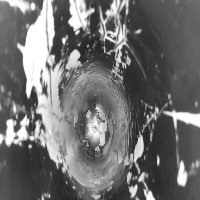

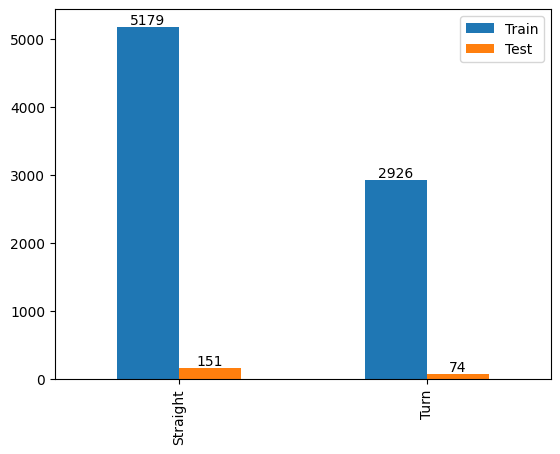

In [ ]:
# Setup path to data folder
data_path = Path("/content/drive/MyDrive/a_1_frames")
image_path = data_path / "images"

if image_path.is_dir():
    print(f"{image_path} directory exists.")

    def walk_through_dir(image_path_path):
      for dirpath, dirnames, filenames in os.walk(image_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

    walk_through_dir(data_path)

    train_dir = image_path / "train"
    test_dir = image_path / "test"

    df = pd.DataFrame({'Train': [5179, 2926], 'Test': [151,74]}, index=['Straight', 'Turn'])
    ax = df.plot.bar()

    for container in ax.containers:
        ax.bar_label(container)

    # Set seed
    random.seed(42)

    image_path_list = list(image_path.glob("*/*/*.png"))
    random_image_path = random.choice(image_path_list)
    image_class = random_image_path.parent.stem
    img = Image.open(random_image_path)

    # 5. Print metadata
    print(f"Random image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.height}")
    print(f"Image width: {img.width}")

else:
    print(f"Did not find {image_path} directory.")
img


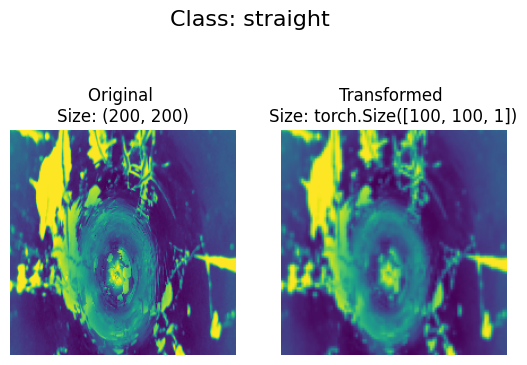

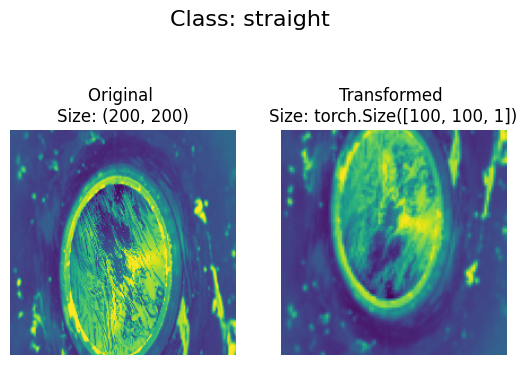

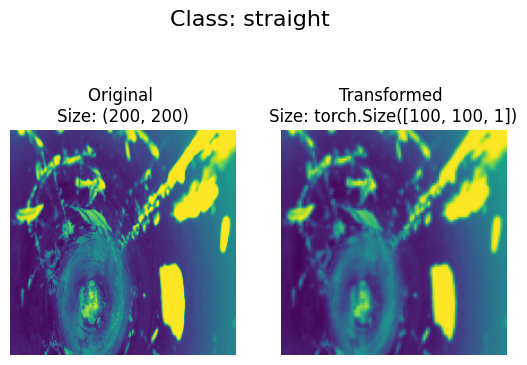

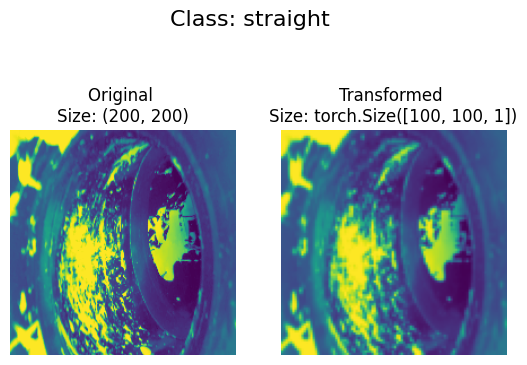

In [ ]:

data_transform = transforms.Compose([
    # Grayscale
    transforms.Grayscale(),
    # Resize
    transforms.Resize((100,100)),
    # Flip the images randomly on the vertical (they're already horizontally flipped)
    transforms.RandomVerticalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

image_paths = [train_dir / "straight", train_dir / "turn"]

def plot_transformed_images(image_paths, transform, n=3, seed=42):

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=4)

Train data:
Dataset ImageFolder
    Number of datapoints: 8448
    Root location: /content/drive/MyDrive/a_1_frames/images/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               RandomVerticalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 293
    Root location: /content/drive/MyDrive/a_1_frames/images/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               RandomVerticalFlip(p=0.5)
               ToTensor()
           )


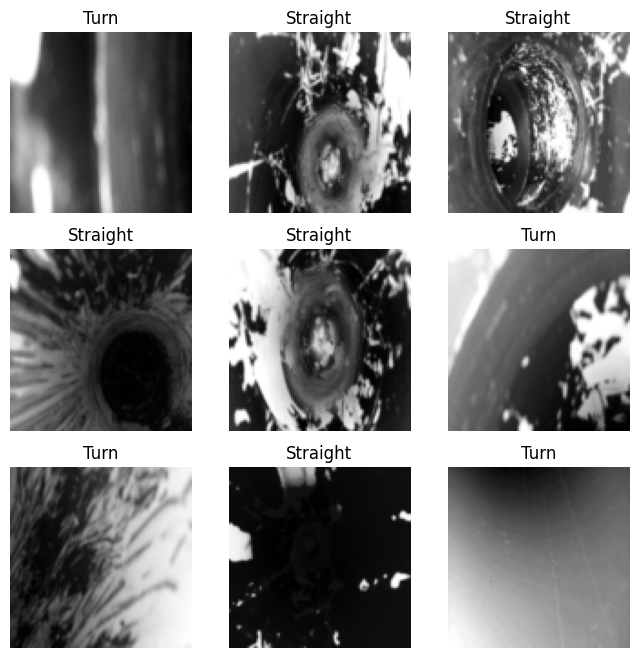

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")


# Prepare loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True, num_workers=0)
num_epochs = 20

labels_map = {
    0: "Straight",
    1: "Turn",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    transformed_image = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(transformed_image.squeeze(), cmap="gray")
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=10, out_channels=15, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=15, out_channels=18, kernel_size=3, padding=1)

        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU(inplace=True)

        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        # Instantiate a fully connected layer
        self.fc1 = nn.Linear(2880, 60)

        # Instantiate a 2nd fully connected layer
        self.fc2 = nn.Linear(60, 20)

        # Instantiate a 3rd fully connected layer
        self.fc3 = nn.Linear(20, 2)

        # Instantiate a 3rd fully connected layer
        self.fc4 = nn.Linear(15, 10)

        # Instantiate a 3rd fully connected layer
        self.fc5 = nn.Linear(10, 2)


    def forward(self, x):
        # Apply conv followed by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        # Apply conv followed by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Prepare the image for the fully connected layer
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu(self.fc2(x))

        # Apply the fully connected layer and return the result
        return self.fc3(x)

In [ ]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 5
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad()

      # Compute the forward pass
      outputs = net(inputs)

      # Compute the loss function
      loss = criterion(outputs, labels)

      # Compute the gradients
      loss.backward()
      running_loss += loss.item()

      # Update the weights
      optimizer.step()
      print(i)

  epoch_loss = running_loss/len(train_loader.dataset)
  print('Epoch loss:', epoch_loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
net.eval()
import time
net.eval()
starttime = time.time()
dSQ = 6000 # data set quantity
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/whole sets/images ds2_2_',
                                 transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)
count = 0
count2 = 0
for i, data in enumerate(test_loader):
    count2 = count2+1
    # Get the image and label from data
    image, label = data

    # Make a forward pass in the net with your image
    output = net(image)

    # Argmax the results of the net
    _, predicted = torch.max(output.data, 1)

    if predicted == label:
        print("Yipes, your net made the right prediction " + str(predicted))
        count = count + 1
    else:
        print("Your net prediction was " + str(predicted) + ", but the correct label is: " + str(label))

    if i > dSQ:
        break

inf = (time.time() - starttime)/dSQ
acc = float(count/count2)
print("accuracy: ", acc)

Your net prediction was tensor([1]), but the correct label is: tensor([0])
Your net prediction was tensor([1]), but the correct label is: tensor([0])
Your net prediction was tensor([0]), but the correct label is: tensor([1])
Your net prediction was tensor([0]), but the correct label is: tensor([1])
Your net prediction was tensor([0]), but the correct label is: tensor([1])
Yipes, your net made the right prediction tensor([1])
Your net prediction was tensor([0]), but the correct label is: tensor([1])
Yipes, your net made the right prediction tensor([1])
Yipes, your net made the right prediction tensor([1])
Your net prediction was tensor([0]), but the correct label is: tensor([1])
Your net prediction was tensor([0]), but the correct label is: tensor([1])
Your net prediction was tensor([0]), but the correct label is: tensor([1])
Your net prediction was tensor([0]), but the correct label is: tensor([1])
Your net prediction was tensor([0]), but the correct label is: tensor([1])
Your net pred

OSError: image file is truncated (37 bytes not processed)

In [ ]:
torch.save(net,"/content/drive/MyDrive/a_1_frames/models/net3")


In [ ]:
correct

NameError: name 'correct' is not defined